### Import Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from utils import visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
USE_GPU = True

if USE_GPU and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: mps


### Visualization of the Dataset

KakaoTalk_20230530_204842937_29_jpg.rf.9a4c13dba3bb1cae7153ed792dbe2c81.jpg


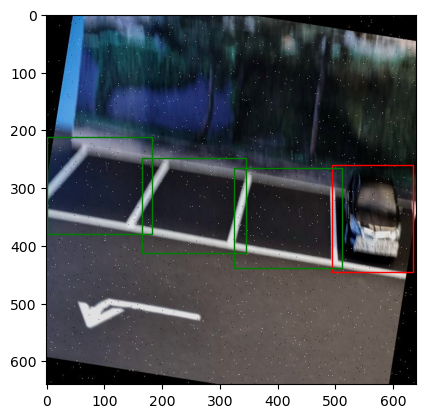

torch.Size([1, 448, 448])


In [3]:
from dataset import ParkingSpotDataset
from utils import visualization

train_dataset = ParkingSpotDataset(image_size=448, data_dir="data/Parking Space.v4i.darknet/train", transform=None)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

for i, (image, target) in enumerate(train_loader):
    image = image.to(device)
    target = target.to(device)
    print(image.shape)
    break

### Training

In [10]:
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
from utils.detection import *
from utils.visualization import *
from loss import *
from dataset import *
from model.yolov1 import *
from torch.utils import model_zoo

USE_GPU = True

# if USE_GPU and torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')
dtype = torch.float32
if USE_GPU and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

lr = 0.001
batch_size = 64
weight_decay = 0.0005
epochs = 20
data_dir = "data/train"

def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

model = YOLOv1(S=7, B=2, C=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss = YoloLoss(S=7, B=2, C=2)

# train_dataset = ParkingSpotDataset(
#     image_size=448,
#     data_dir=data_dir,
#     S=7,
#     B=2,
#     C=2
# )

# train_loader = DataLoader(
#     dataset=train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     drop_last=True,
# )
model.train()
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        predict= model(inputs)
        print("done")
        # loss = loss_fn(predict, targets)
        # loss.backward()
        # optimizer.step()
        print(f"Loss: {loss.item()}")
    train_fn(train_loader, model, optimizer, loss)


Epoch 0
done


AttributeError: 'YoloLoss' object has no attribute 'item'

Using cache found in /Users/andrewpark/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-3-22 Python-3.9.18 torch-2.3.0.dev20240226 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
image 1/1: 640x640 3 cars, 1 surfboard
Speed: 7.6ms pre-process, 139.3ms inference, 0.8ms NMS per image at shape (1, 3, 640, 640)
Saved 1 image to runs/detect/exp3


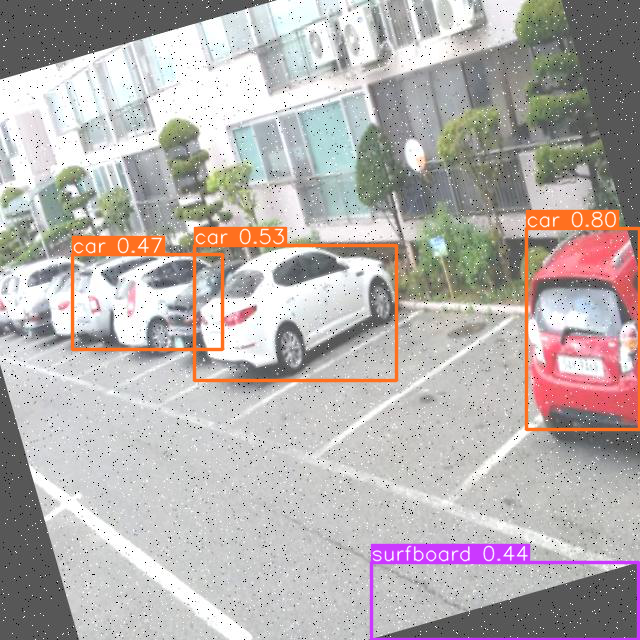

In [3]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ['data/Parking Space.v4i.darknet/train/-2023-05-03-092932_png_jpg.rf.4119d4d07bc54c3b0ae7bfdd37d5e7a3.jpg']  # batch of images

# Inference
results = model(imgs)

# Results
results.print()
results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (pandas)
#      xmin    ymin    xmax   ymax  confidence  class    name
# 0  749.50   43.50  1148.0  704.5    0.874023      0  person
# 1  433.50  433.50   517.5  714.5    0.687988     27     tie
# 2  114.75  195.75  1095.0  708.0    0.624512      0  person
# 3  986.00  304.00  1028.0  420.0    0.286865     27     tie

results.show()  # show results